# Recurrent Neural Network 
Recurrentin anlamı bir timestampte ki output başka bir timestampte input olur. Modelin sadece o andaki inputu değil geçmiş bilgileride memoryde tutmasına yarar. Bu memory sayesinde model long-term dependencies leri öğreni yani. Prediction yaparken geçmiş bilgileri de hesaba katar. Insanların bişeyleri sıralaması mantığında gibi çalışır. Biz bir şey duyduğumuzda bunu kelime kelime olarak ayırmayız tüm cümleyi hesaba katarız. <br>
RNN lerin en önemli katmanı memory celldir. En populer memory cell LSTM dir. Geçmişten bilgiyi taşırken belli oranda mevcut bilgileri de taşır. Duruma göre değişirtirir. LSTM geçmişten gelen bilginin ileriye gidildikçe kaybolmadığından emin olmaya çalışır.  <br>
Forget Gate , Input Gate ,Outpu Gate bulunur. 


### Adımlar 
1. String leri integerlara çevirr.
2. Sequenceslerden Feature ve Label oluştur. 
3. Embedding , LSTM , Dense layer olan bir LSTM modeli oluştur 
4. Pre trained Embeddingleri yükle 
5. Modeli sequencesteki bir sonraki kelimeyi tahmin etmek için eğit
6. Tahmin yapabilmek için sequences gönder

In [123]:
import warnings 

warnings.filterwarnings("ignore",category = RuntimeWarning)


RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = .7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3334003589357377439
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1450105241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16876553793335945092
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [15]:
import pandas as pd
import numpy as np

data = pd.read_csv("D://MachineLearningCourse//Datasets/neural_network_patent_query.csv",parse_dates=["patent_date"])

orginal_abstracts = list(data.patent_abstract)
print(len(orginal_abstracts))

data.head()

3522


,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [16]:
data["patent_abstract"][100]

'The present invention provides an apparatus and a method for classifying and recognizing image patterns using a second-order neural network, thereby achieving high-rate parallel processing while lowering the complexity. The second-order neural network, which is made of adders and multipliers, corrects positional translations generated in a complex-log mapping unit to output the same result for the same object irrespective of the scale and/or rotation of the object. The present invention enables high-rate image pattern classification and recognition based on parallel processing, which is the advantage obtained in neural network models, because consistent neural networks and consistent network structure computation models are applied to all steps from the image input step to the pattern classifying and recognizing step.'

C:\Users\bagat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


Text(0.5, 1.0, 'Neural network patents ove time')

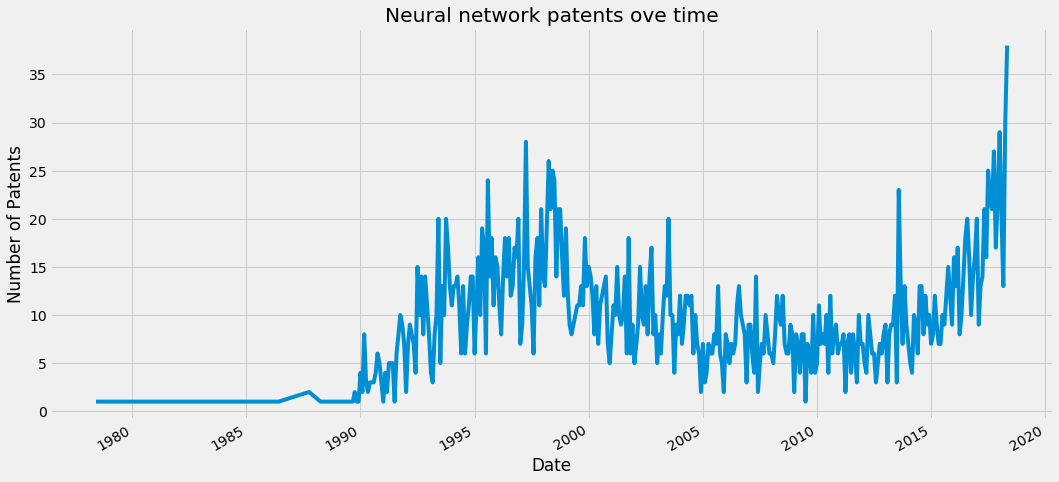

In [17]:
import matplotlib.pyplot as plt 


plt.style.use("fivethirtyeight")

data["year-month"] = [pd.datetime(year,month,1)  for year,month  in zip(data["patent_date"].dt.year,data["patent_date"].dt.month)   ]

monthly = data.groupby("year-month")["patent_number"].count().reset_index()

monthly.set_index("year-month")["patent_number"].plot(figsize=(16,8))
plt.ylabel("Number of Patents")
plt.xlabel("Date")
plt.title("Neural network patents ove time")

Text(0.5, 1.0, 'Neurla network Patents by year')

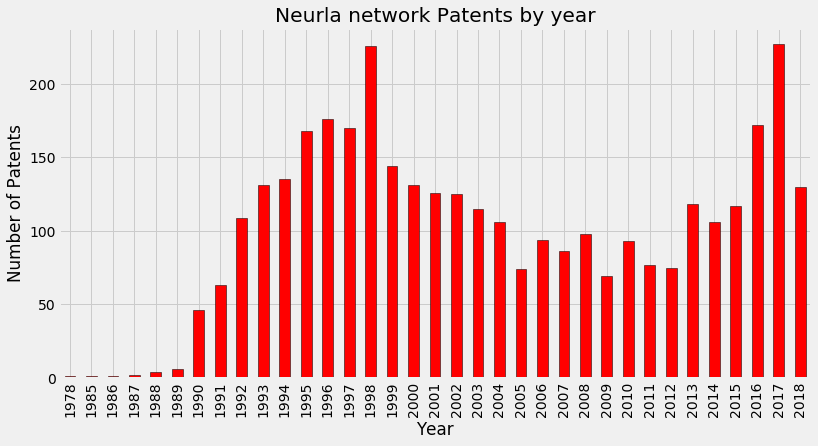

In [18]:
monthly.groupby(monthly["year-month"].dt.year)["patent_number"].sum().plot.bar(
color="red",edgecolor="k",figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Neurla network Patents by year")

## Veri Temizleme 
Tokenizer kullanarak stringleri int degerlere çeviricez. 

In [19]:
from keras.preprocessing.text import Tokenizer

example = 'This is a short sentence (1) with one reference to an image. This next sentence, while non-sensical, does not have an image and has two commas.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
" ".join(tokenizer.index_word[i] for i in s)

'this is a short sentence 1 with one reference to an image this next sentence while non sensical does not have an image and has two commas'

In [20]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]

print(" ".join(tokenizer.index_word[i] for i in s )
)
tokenizer.word_index.keys()

this is a short sentence (1) with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.


dict_keys(['this', 'an', 'is', 'a', 'short', 'sentence', '(1)', 'with', 'one', 'reference', 'to', 'image.', 'next', 'sentence,', 'while', 'non-sensical,', 'does', 'not', 'have', 'image', 'and', 'has', 'two', 'commas.'])

Yukarıda görüldüğü gibi image. ve image ayrı kelimler gibi seçilmiş bunun için regular expression kullanılabilir. 

In [21]:
import re 

def format_patent(patent):
    ### noktalama işaretlerinin etrafına space ekleyerek onları kaldırmak için 
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)
    
        # Figure referanslarını kaldırmak için 
    patent = re.sub(r'\((\d+)\)', r'', patent)
    
    #double spaceleri kaldırmak için 
    patent = re.sub(r'\s\s', ' ', patent)
    
    return patent
f = format_patent(example)
f

'This is a short sentence with one reference to an image . This next sentence , while non-sensical , does not have an image and has two commas .'

In [22]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([f])
s = tokenizer.texts_to_sequences([f])[0]
print(" ".join(tokenizer.index_word[i] for i in s))

tokenizer.word_index.keys()

this is a short sentence with one reference to an image . this next sentence , while non-sensical , does not have an image and has two commas .


dict_keys(['this', 'sentence', 'an', 'image', '.', ',', 'is', 'a', 'short', 'with', 'one', 'reference', 'to', 'next', 'while', 'non-sensical', 'does', 'not', 'have', 'and', 'has', 'two', 'commas'])

In [23]:
##orginal cümleyi getirmek için
def remove_spaces(patent):
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)
    
    return patent

remove_spaces(" ".join(tokenizer.index_word[i] for i in s ))

'this is a short sentence with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

In [25]:
formatted = []

for a in orginal_abstracts:
    formatted.append(format_patent(a))
    
len(formatted)

3522

# Texti Sequencesler çevir
Neural netwokü eğitmek için sayılara ihtiyacımız var. Tokenizer ile bunu sağlayabiliriz.Tüm kelimeleri lower case ve noktalama işaretlerini kaldırır. 

## Features ve Labels 
Networke feature olarak bir sequences göndericez ve label olarak bu sequencesten sonra gelicek kelimeyi belirlicez.  50 kelime train için alıcak ve 51. kelime label olucak. <br>
Her bir abstract(metin) için multiple training örneği yapabiliriz. feat : 0 -50 label : 51. ---- feat : 1-51 label 52. -- ---- şeklinde parselayabiliriz. Bu bize daha fazla data olanağı sağlar. 

In [26]:
def make_sequences(texts,training_lenth=50,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    
    
    # Tokenizer objesi oluştur ve text ile eğit
    tokenizer = Tokenizer(filters=filters,lower=lower)
    tokenizer.fit_on_texts(texts)
    
    ## Sözlükler oluştur 
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx)+1
    word_counts = tokenizer.word_counts
    
    print(f"Toplamda {num_words} unique kelime var.")
    
    ## texti sequences e çevir
    sequences = tokenizer.texts_to_sequences(texts)
    
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i ,l in enumerate(seq_lengths) if l >(training_lenth+20)
    ]
    
    new_texts = []
    new_sequences = []
    
    # Sadece training length den fazla olan sequencesleri tut 
    
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])
        
    
    training_seq = []
    labels = []
    
    for seq in new_sequences:
        
        for i in range(training_lenth,len(seq)):
            extract = seq[i-training_lenth:i+1]
            
            training_seq.append(extract[:-1])
            labels.append(extract[-1])
        
        
    print(f"Toplamda {len(training_seq)} kadar sequences var")
    
    
    return word_idx,idx_word,num_words,word_counts,new_texts,new_sequences,training_seq,labels
         

In [27]:
TRAINING_LENGTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=True, filters=filters)

Toplamda 13677 unique kelime var.
Toplamda 320881 kadar sequences var


In [31]:
n = 3 
features[n][:10]

[3086, 1978, 11, 2, 9, 8, 19, 27, 5, 117]

In [32]:
def find_answer(index):
    # her feature için labelı bul 
    
    feats = " ".join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]
    
    print("Features :",feats)
    print("\nLabel : ",answer)

In [33]:
find_answer(3)

Features : enhances stability in a neural network system that , when used as a track-while-scan system , assigns sensor plots to predicted track positions in a plot track association situation . the barometer neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a

Label :  zero


In [34]:
orginal_abstracts[0]


'" A ""Barometer"" Neuron enhances stability in a Neural Network System that, when used as a track-while-scan system, assigns sensor plots to predicted track positions in a plot/track association situation. The ""Barometer"" Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a ""perfect"" pairing of plot and track which has a measured/desired level of inhibition. The ""Barometer"" Neuron responds to the System inputs, compares these inputs against the level of inhibition of the ""perfect"" pair, and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0; this the reference level of inhibition of the ""perfect"" pair. "'

In [35]:
find_answer(100)

Features : it comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem , such as the number of cities to be visited . the array is prompted by analog voltages representing variables such as distances . the processor incorporates two interconnected feedback

Label :  networks


In [56]:
sorted(word_counts.items(),key= lambda x : x[1] ,reverse=True)[:15]

[('the', 36597),
 ('a', 24883),
 ('of', 20193),
 ('.', 16604),
 (',', 15417),
 ('and', 12947),
 ('to', 12073),
 ('network', 7733),
 ('neural', 7381),
 ('is', 7213),
 ('in', 6992),
 ('for', 6907),
 ('an', 6061),
 ('data', 4010),
 ('by', 3607)]

# Training Data
## Encoding Labels 
En önemli adımlardan biride labelları one-hot-encoding'e çevirmektir. Loss olarak categorical_crossentropy kullanılacağı için tüm sözlükten 1 kelime tahmin etmeye çalışacağız...  [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,,0,0]

In [36]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [37]:
X_train,X_valid ,y_train,y_valid = create_train_valid(features,labels,num_words)
print(X_train.shape)
print(y_train.shape)

(224616, 50)
(224616, 13677)


In [46]:
# unused objeleri silerek memory probleminden kurtulabilriz.
import sys 
sys.getsizeof(y_train)/1e9

3.072073144

In [49]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x))/1e9
        if size>gb_min:
            print(f"Object {x:10}\tsize:{size} GB")

In [50]:
check_sizes(gb_min=1)

Object y_train   	size:3.072073144 GB
Object y_valid   	size:1.316616517 GB
Object _39       	size:3.072073144 GB


In [54]:
glove_vectors = "D:\\MachineLearningCourse\\Datasets\\glove.6B.100d.txt"
glove = np.loadtxt(glove_vectors, dtype='str', comments=None,encoding="utf-8")
glove.shape

(400000, 101)

word ve vektörlere ayırma işlemi

In [55]:
vectors = glove[:,1:].astype("float")
words = glove[:,0]

vectors[100],words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

In [56]:
del glove

In [57]:
vectors.shape

(400000, 100)

In [60]:
word_lookup = {word:vector for word , vector in zip(words,vectors)}

embedding_matrix = np.zeros((num_words,vectors.shape[1]))

not_found=0

for i,word in enumerate(word_idx.keys()):
    vector = word_lookup.get(word,None)

    if vector is not None:
        embedding_matrix[i+1,:] = vector
    else :
        not_found +=1
    
print(f"There were {not_found} words without pre-trained embeddings")    

There were 2941 words without pre-trained embeddings


Her kelime 100 sayı ile temsil edilir hale getirildi. Belli bir kelimeye yakın kelimeleri cosine distance hesaplayarak bulabiliriz. Vectorleri normalize ederek bunu sağlayabiliriz.

In [65]:
embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix,axis=1).reshape((-1,1))
embedding_matrix = np.nan_to_num(embedding_matrix)

In [114]:
def find_closest(query,embedding_matrix,word_idx,idx_word,n=10):
    
    idx = word_idx.get(query,None)
    
    if idx is None :
        print(f"{query} not found in vocab")
        return 

    else: 
        vec = embedding_matrix[idx]
        if np.all(vec==0):
            print(f"{query} has no pretrained embeddings")
            return 
        else :  
            dists = np.dot(embedding_matrix,vec) 
            
            idxs = np.argsort(dists)[::-1][:n] # indexleri döndürür büyükten küçüğe 
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]
            
            
    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [115]:
find_closest('close', embedding_matrix, word_idx, idx_word)

Query: close

Word: close           Cosine Similarity: 1.0
Word: up              Cosine Similarity: 0.7662
Word: down            Cosine Similarity: 0.7525
Word: while           Cosine Similarity: 0.7419
Word: at              Cosine Similarity: 0.7409
Word: far             Cosine Similarity: 0.7378
Word: just            Cosine Similarity: 0.7224
Word: point           Cosine Similarity: 0.7208
Word: another         Cosine Similarity: 0.7163
Word: time            Cosine Similarity: 0.7102


# Build Model 
Kelimlerin embeddinglerini LSTM layera göndeririz. Buradan Dense layera, ve en son softmax activasyona ginder burada softmax her bir çıktı için prob üretir. hangi kelimenin olduğu probu en yüksek hesapladığı. 



In [118]:
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Dropout,Embedding,Masking,Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [124]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)
model.summary()        

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1367700   
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13677)             1764333   
Total params: 3,182,593
Tr

In [146]:
# from IPython.display import Image
model_name = 'D:\\MachineLearningCourse\\Practice\\Deep Learning\\models\\pre-trained-rnn.h5'
model_dir = ''

# plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

# Image(f'{model_dir}{model_name}.png')

# Train Model
validation loss değeri artık düşmüyorsa Early Stopping ile eğitimi durdurabiliriz. Her seferinde best weightleri save ederek iyi modeli daha sonra kullanabiliriz. <br>
Early Stopping : Eğitimi durdur<br>
Model Checkpoint: Best modeli diske kaydet

In [147]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

In [148]:
# history = model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,
#                     verbose=VERBOSE,callbacks=callbacks,validation_data=(X_valid,y_valid))

In [149]:
def load_and_evaluate(model_name,return_model=False):
    
    model = load_model(model_name)
    r = model.evaluate(X_valid,y_valid,batch_size=2048,verbose=1)
    
    valid_crossentopy = r[0]
    valid_accuracy = r[1]
    
    print(f"Loss : {round(valid_crossentopy,4)}")
    print(f"Accuracy : {round(valid_accuracy,2)}%")
    
    if return_model:
        return model

In [150]:
model = load_and_evaluate(model_name,return_model=True)

96265/96265 [==============================] - 28s 289us/step
Loss : 5.2542
Accuracy : 0.24%


In [156]:
np.random.seed(40)

total_words = sum(word_counts.values())

frequencies = [word_counts[word]/total_words for word in word_idx.keys()]
frequencies.insert(0,0)



In [158]:
frequencies[1:10],list(word_idx.keys())[:9]

([0.07345992492824023,
  0.049946807442943456,
  0.040532728477087054,
  0.03332864971195729,
  0.030946024609084886,
  0.025988076838154118,
  0.024233726088440155,
  0.015522190328990947,
  0.014815632589975713],
 ['the', 'a', 'of', '.', ',', 'and', 'to', 'network', 'neural'])

In [184]:
print(
    f'The accuracy is {round(100 * np.mean(np.argmax(y_valid, axis = 1) == 1), 4)}%.'
)

The accuracy is 8.7207%.


In [186]:
random_guesses = []

for i in range(len(y_valid)):
    random_guesses.append(
    np.argmax(np.random.multinomial(1,frequencies,size=1)[0])
    )

In [192]:
from collections import Counter 

c = Counter(random_guesses)

for i in c.most_common(10):
    word = idx_word[i[0]]
    word_count = word_counts[word]
    
    
    print(
        f'Word: {word} \tCount: {word_count} \tPercentage: {round(100 * word_count / total_words, 2)}% \tPredicted: {i[1]}'
    )

Word: the 	Count: 36597 	Percentage: 7.35% 	Predicted: 7104
Word: a 	Count: 24883 	Percentage: 4.99% 	Predicted: 4829
Word: of 	Count: 20193 	Percentage: 4.05% 	Predicted: 3877
Word: . 	Count: 16604 	Percentage: 3.33% 	Predicted: 3292
Word: , 	Count: 15417 	Percentage: 3.09% 	Predicted: 2992
Word: and 	Count: 12947 	Percentage: 2.6% 	Predicted: 2464
Word: to 	Count: 12073 	Percentage: 2.42% 	Predicted: 2356
Word: network 	Count: 7733 	Percentage: 1.55% 	Predicted: 1463
Word: is 	Count: 7213 	Percentage: 1.45% 	Predicted: 1428
Word: in 	Count: 6992 	Percentage: 1.4% 	Predicted: 1384


In [193]:
from IPython.display import HTML


def header(text, color='black'):
    raw_html = f'<h1 style="color: {color};"><center>' + \
        str(text) + '</center></h1>'
    return raw_html


def box(text):
    raw_html = '<div style="border:1px inset black;padding:1em;font-size: 20px;">' + \
        str(text)+'</div>'
    return raw_html


def addContent(old_html, raw_html):
    old_html += raw_html
    return old_html

In [194]:
import random

def generate_output(model,sequences,training_length=50,new_words=50,diversity = 1,return_output=False,n_gen=1):
    
    seq = random.choice(sequences)
    
    seed_idx = random.randint(0,len(seq)-training_length-10)
    
    end_idx = seed_idx+training_length
    
    gen_list = []
    
    for n in range(n_gen)

In [262]:
n = 355

In [263]:
pred = model.predict(X_valid[n].reshape(1,-1))

In [264]:
" ".join(idx_word[i] for i in X_valid[n])

'from unfamiliar text , a tutor gives feedback designed to assist the brain realize its current reading strategies are not producing the desired results and the erroneously-built neural network needs remodeling . during the independent reading component , the brain experiments with the strategy ideas formulated as a result of'

In [265]:
idx_word[np.argmax(y_valid[n])]

'experiencing'

In [266]:
idx_word[np.argmax(pred)]

'the'